### Medical Image Classification
In this exercise, we will train an image classification model using SageMaker Training. We will then download the trained model locally to generate predictions on a test dataset. Finally, we will generate evaluation metrics for our model and plot the confusion matrix and the ROC Curve. 

#### Prerequisites
1. Make sure that the dataset file "chest_xray_train.zip" is uploaded to the S3 location as described in *Chapter 6* section, *Acquiring the dataset and code*, *steps 1* through *4*.
2. Make sure the local notebook instance (this instance) has the data and the scripts arranged in the directory strucure described in *Chapter 6* section, *Acquiring the dataset and code*, *steps 5* through *7*.



###Training the classification model

Now, we're ready to start.

1. Let's begin by upgrading Sagemaker and installing autogluon locally.

In [ ]:
!pip install --upgrade sagemaker
!pip3 install -U pip
!pip3 install -U setuptools wheel
!pip3 install autogluon

2. Next, we will import the necessary libraries. Make sure the directory "scripts" and the associated files are present before running the next cell.

In [ ]:
import os
import sagemaker
import boto3
import pandas as pd
from sklearn import metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.ag_model import (
    AutoGluonTraining,
    AutoGluonInferenceModel)
from sagemaker import utils
import autogluon.core as ag
from autogluon.vision import ImagePredictor, ImageDataset

3. Let's look at a few sample images from our test set. 

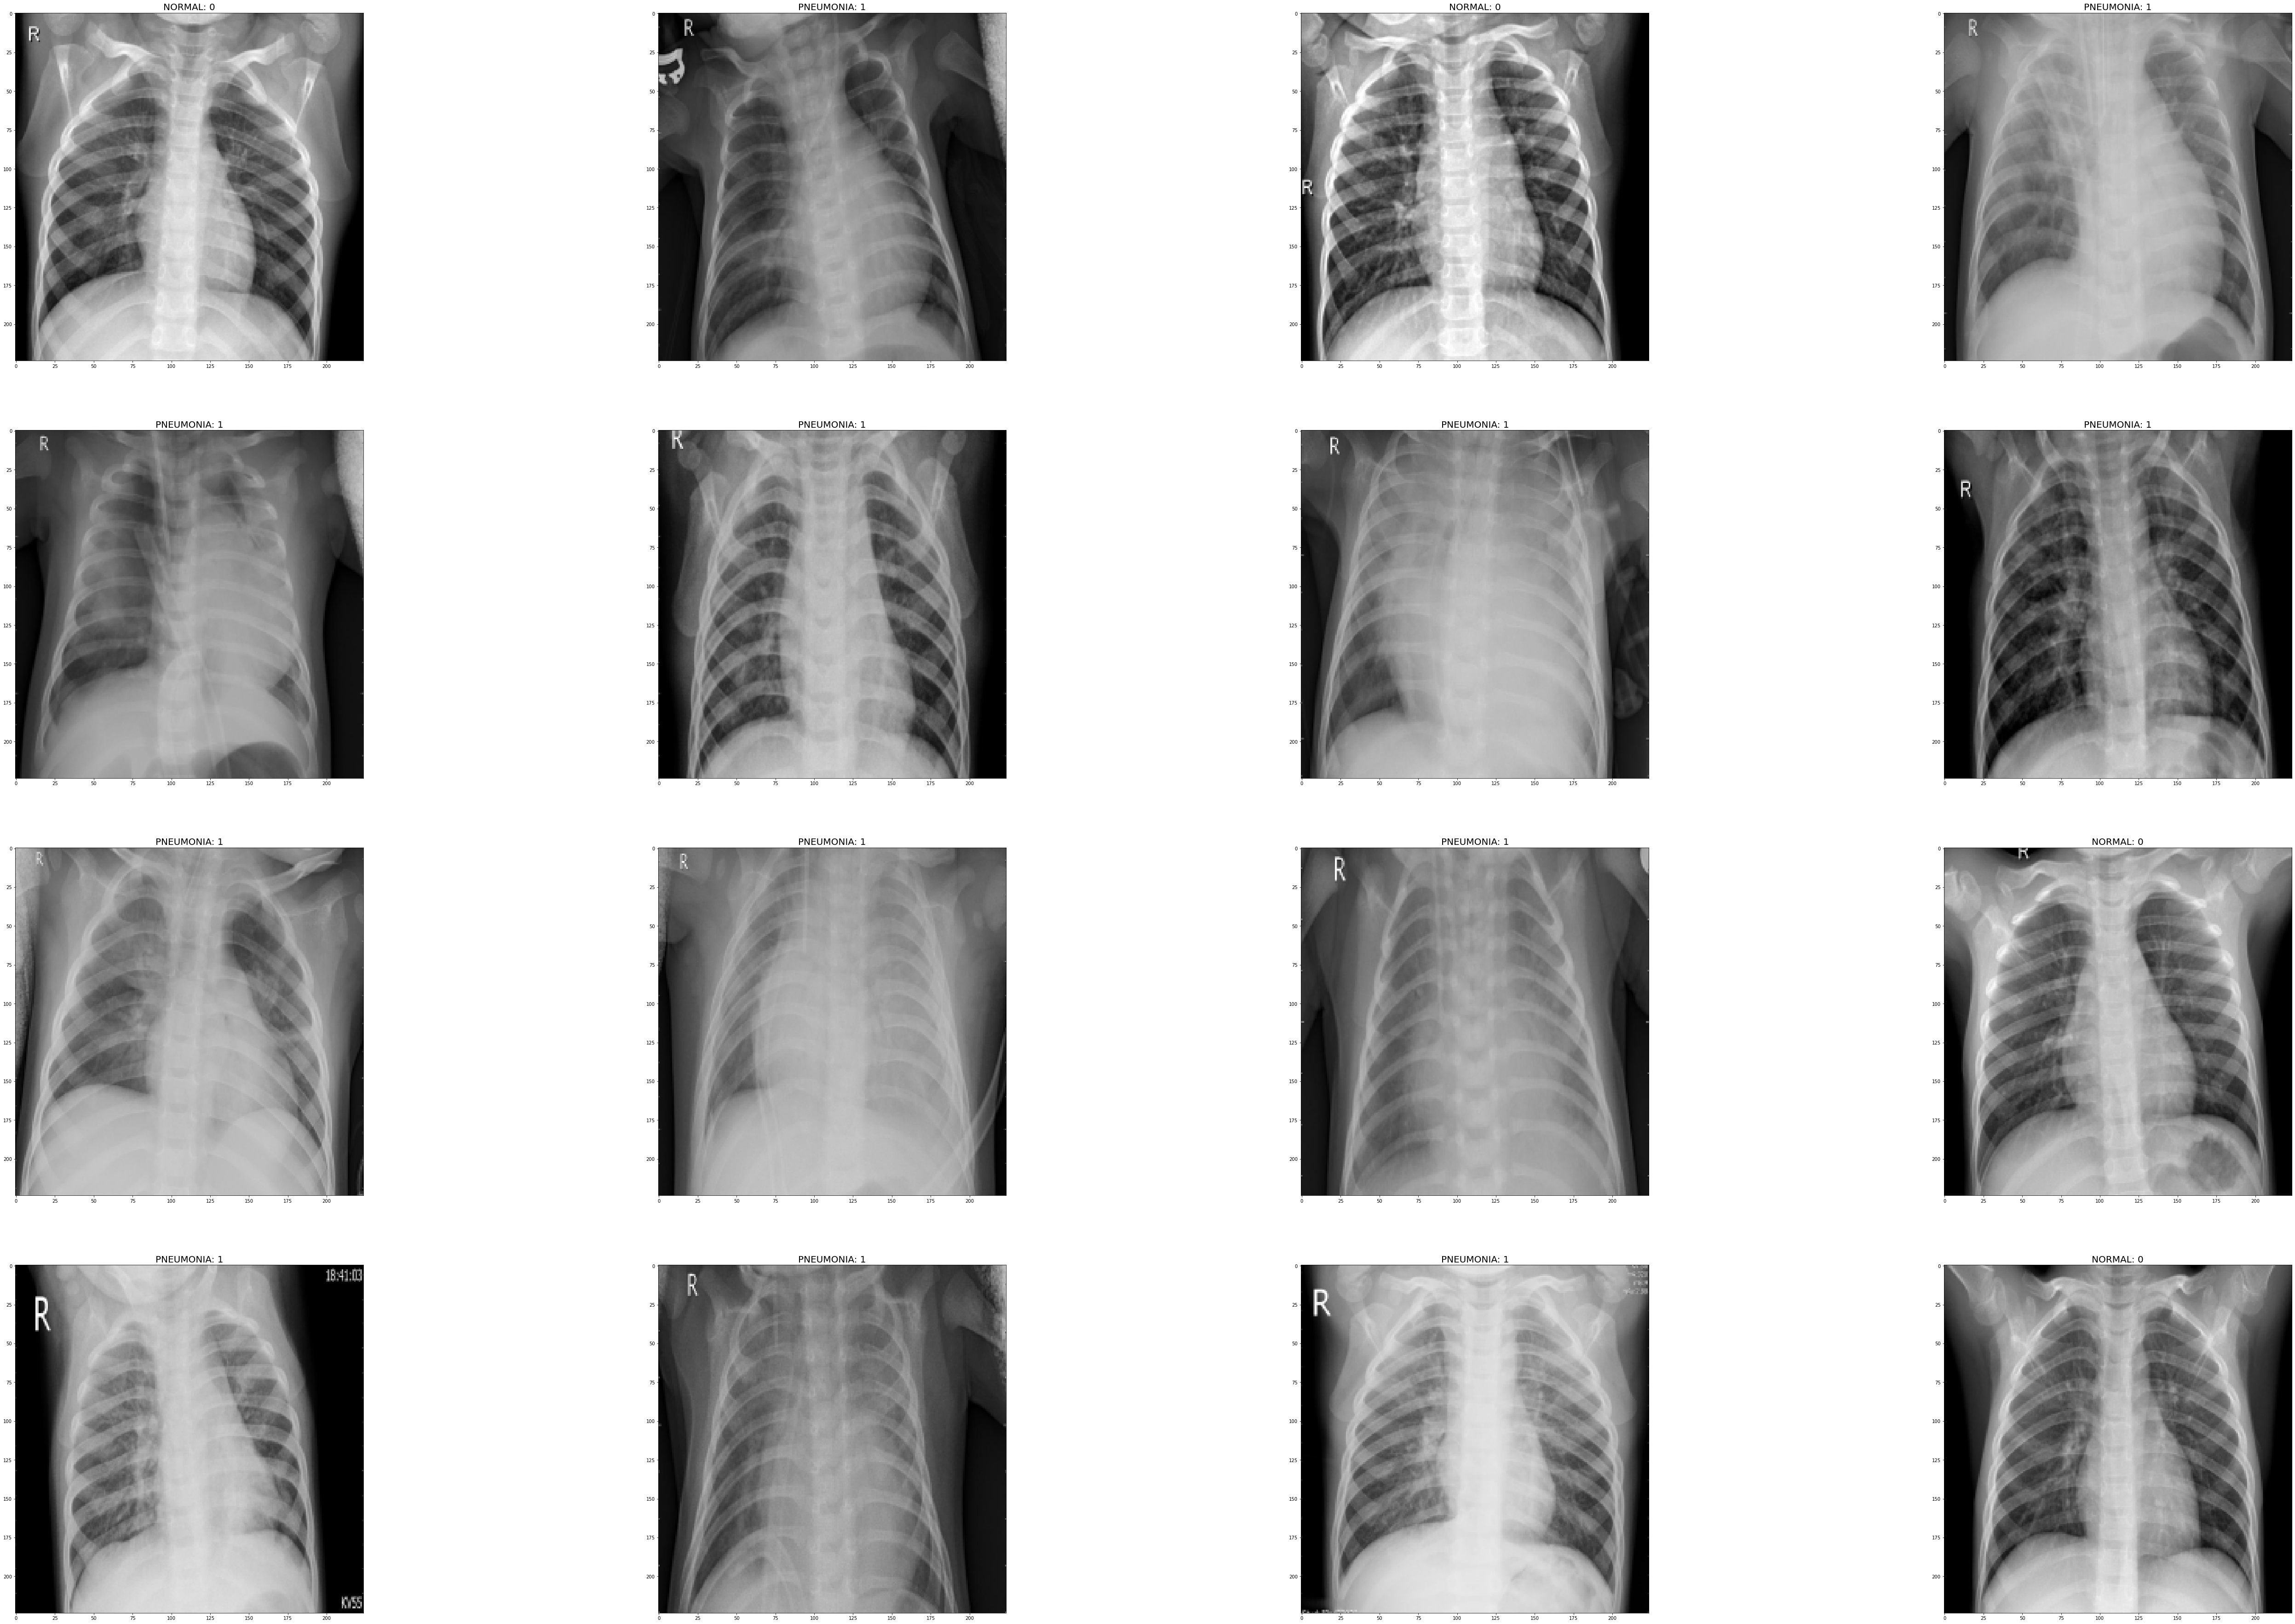

In [ ]:
_, _, test_dataset = ImageDataset.from_folders('data', test='test')
test_dataset.show_images()

4. We will now create some global variables we will use in our notebook. 
Make sure you enter the path to your chest_xray_train.zip file in the last line of the following code cell.

In [ ]:
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session._region_name

bucket = sagemaker_session.default_bucket()
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
output_path = f"s3://{bucket}/{s3_prefix}/output/"

data_path = "" #enter path to your chest_xray_train.zip file on S3 between double quotes in the format s3://bucket/prefix/chest_xray_train.zip

5. Let us now create a training script. This is the script that Sagemaker will run when training the model. Go through the script to understand how Sagemaker runs training. 

In [ ]:
%%writefile scripts/imagepredictortrain.py
import argparse
import os
import autogluon.core as ag
from autogluon.vision import ImageDataset, ImagePredictor
import zipfile
import boto3


def get_env_if_present(name):
    result = None
    if name in os.environ:
        result = os.environ[name]
    return result


def get_input_path(path):
    file = os.listdir(path)[0]
    if len(os.listdir(path)) > 1:
        print(f"WARN: more than one file is found in {channel} directory")
    print(f"Using {file}")
    filename = f"{path}/{file}"
    return filename
    
if __name__ == "__main__":
    os.environ["MXNET_CUDNN_AUTOTUNE_DEFAULT"] = "0"

    # ------------------------------------------------------------ Args parsing
    print("Starting AG")
    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    parser.add_argument(
        "--output-data-dir", type=str, default=get_env_if_present("SM_OUTPUT_DATA_DIR")
    )
    parser.add_argument("--model-dir", type=str, default=get_env_if_present("SM_MODEL_DIR"))
    parser.add_argument("--n_gpus", type=str, default=get_env_if_present("SM_NUM_GPUS"))
    parser.add_argument("--training_dir", type=str, default=get_env_if_present("SM_CHANNEL_TRAIN"))
    parser.add_argument(
        "--test_dir", type=str, required=False, default=get_env_if_present("SM_CHANNEL_TEST")
    )
    parser.add_argument("--ag_config", type=str, default=get_env_if_present("SM_CHANNEL_CONFIG"))

    args, _ = parser.parse_known_args()

    print(f"Args: {args}")
    
     # ---------------------------------------------------------------- Training

    train_file = get_input_path(args.training_dir)
    
    with zipfile.ZipFile(train_file, 'r') as zip_ref:
        zip_ref.extractall('data') 
    train_data,val_data, _= ImageDataset.from_folders('data', train='train', val='val')
    print('train #', len(train_data), 'val #', len(val_data))
    predictor = ImagePredictor()
    predictor.fit(train_data,val_data)
    predictor.save(os.path.join(args.model_dir, "model.ag"))

Overwriting scripts/imagepredictortrain.py


6. We are now ready to define our training configuration. The following cell creates an autogluon estimator to run on a single ml.p3.2xlarge instance using the script defined earlier.

In [ ]:
ag = AutoGluonTraining(
    role=role,
    entry_point="scripts/imagepredictortrain.py",
    region=region,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version="0.3.1",
    py_version='py37'
)

7. We are now ready to run our training on Sagemaker. The following cell will run the training. You can monitor the progress using the logs produced by the training job. You can view these logs in the AWS cloudwatch console as well.

#### Note: This step takes about 12 mins to complete. 
During this process, Sagemaker spins up the instance, downloads the training data and image and runs training.

In [ ]:
ag.fit({ "train": data_path})

2022-06-28 22:16:40 Starting - Starting the training job...
2022-06-28 22:17:10 Starting - Preparing the instances for trainingProfilerReport-1656454600: InProgress
.........
2022-06-28 22:18:31 Downloading - Downloading input data...
2022-06-28 22:19:07 Training - Downloading the training image..........................This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.download.nvidia.com/licenses/NVIDIA_Deep_Learning_Container_License.pdf
2022-06-28 22:23:21,431 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-06-28 22:23:21,456 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'imagepredictortrain.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_

Make sure the training completes successfully before moving forward.
At the end of the training step, Sagemaker saves the trained model on S3. 

8. We will now download the model on our notebook instance.

In [ ]:
sm_boto3 = boto3.client('sagemaker')
artifact = sm_boto3.describe_training_job(
    TrainingJobName=ag.latest_training_job.name)['ModelArtifacts']['S3ModelArtifacts']

print('Model artifact persisted at ' + artifact)
!aws s3 cp $artifact model/
! tar -xf model/model.tar.gz -C model/

Model artifact persisted at s3://sagemaker-us-east-1-485822383573/autogluon-training-2022-06-28-22-16-40-589/output/model.tar.gz


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


download: s3://sagemaker-us-east-1-485822383573/autogluon-training-2022-06-28-22-16-40-589/output/model.tar.gz to model/model.tar.gz


9. We are ready to generate predictions. Let's create a predictor object and generate predictions on our test data. Also, we will get a baseline model accuracy.

In [ ]:
predictor= ImagePredictor.load('model/model.ag')
test_acc = predictor.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc['top1'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
[Epoch 1] validation: top1=0.865385 top5=1.000000


Top-1 test acc: 0.865


10. Next, we will create a dataframe results with actual, predicted, and predicted probability values for our test images. We will use these values in our metrics and plots.

In [ ]:
predicted=predictor.predict(test_dataset).to_frame(name="predicted").astype(int)
actual=test_dataset['label'].to_frame(name="actual")
predicted_prob=predictor.predict_proba(test_dataset)[1].to_frame(name="predicted_prob").astype(float)
results=pd.concat([actual, predicted, predicted_prob],axis=1)
results.head()

,actual,predicted,predicted_prob
0,0,0,0.214433
1,0,0,0.276369
2,0,0,0.299455
3,0,1,0.518141
4,0,0,0.274836


11. Next, let's get a confusion matrix for our model.

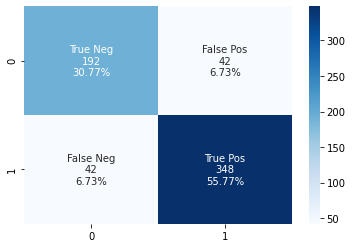

In [ ]:
cf_matrix = metrics.confusion_matrix(results['actual'], results['predicted'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

12. Lastly, we will generate more metrics about our model, and an ROC curve. 

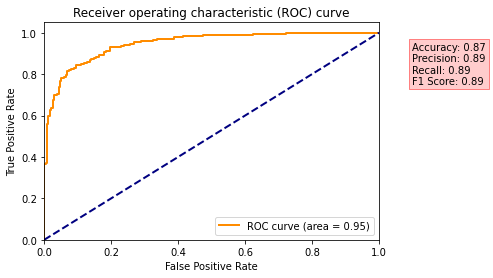

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(results['actual'], results['predicted_prob'])
roc_auc=metrics.auc(fpr, tpr)
accuracy=metrics.accuracy_score(results['actual'], results['predicted'])
precision=metrics.precision_score(results['actual'], results['predicted'])
recall=metrics.recall_score(results['actual'], results['predicted'])
f1score=metrics.f1_score(results['actual'], results['predicted'])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.text(1.1,0.75,s='Accuracy: '+str(round(accuracy,2))+'\nPrecision: '+str(round(precision,2))+
'\nRecall: '+str(round(recall,2))+'\nF1 Score: '+str(round(f1score,2)),bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   ))

plt.show()

This exercise is now complete. Make sure you stop or delete your notebook instance to avoid incurring costs.